In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_csv("./titanic.csv")
df.head()  # print(data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
print(df.shape)
print("")
df.info()

(418, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


/var/folders/ff/xn8h_gc16ll2zb2qh6_dzntm0000gn/T/ipykernel_78008/3971387956.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Fare"],color="g")
/var/folders/ff/xn8h_gc16ll2zb2qh6_dzntm0000gn/T/ipykernel_78008/3971387956.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Age"],color="

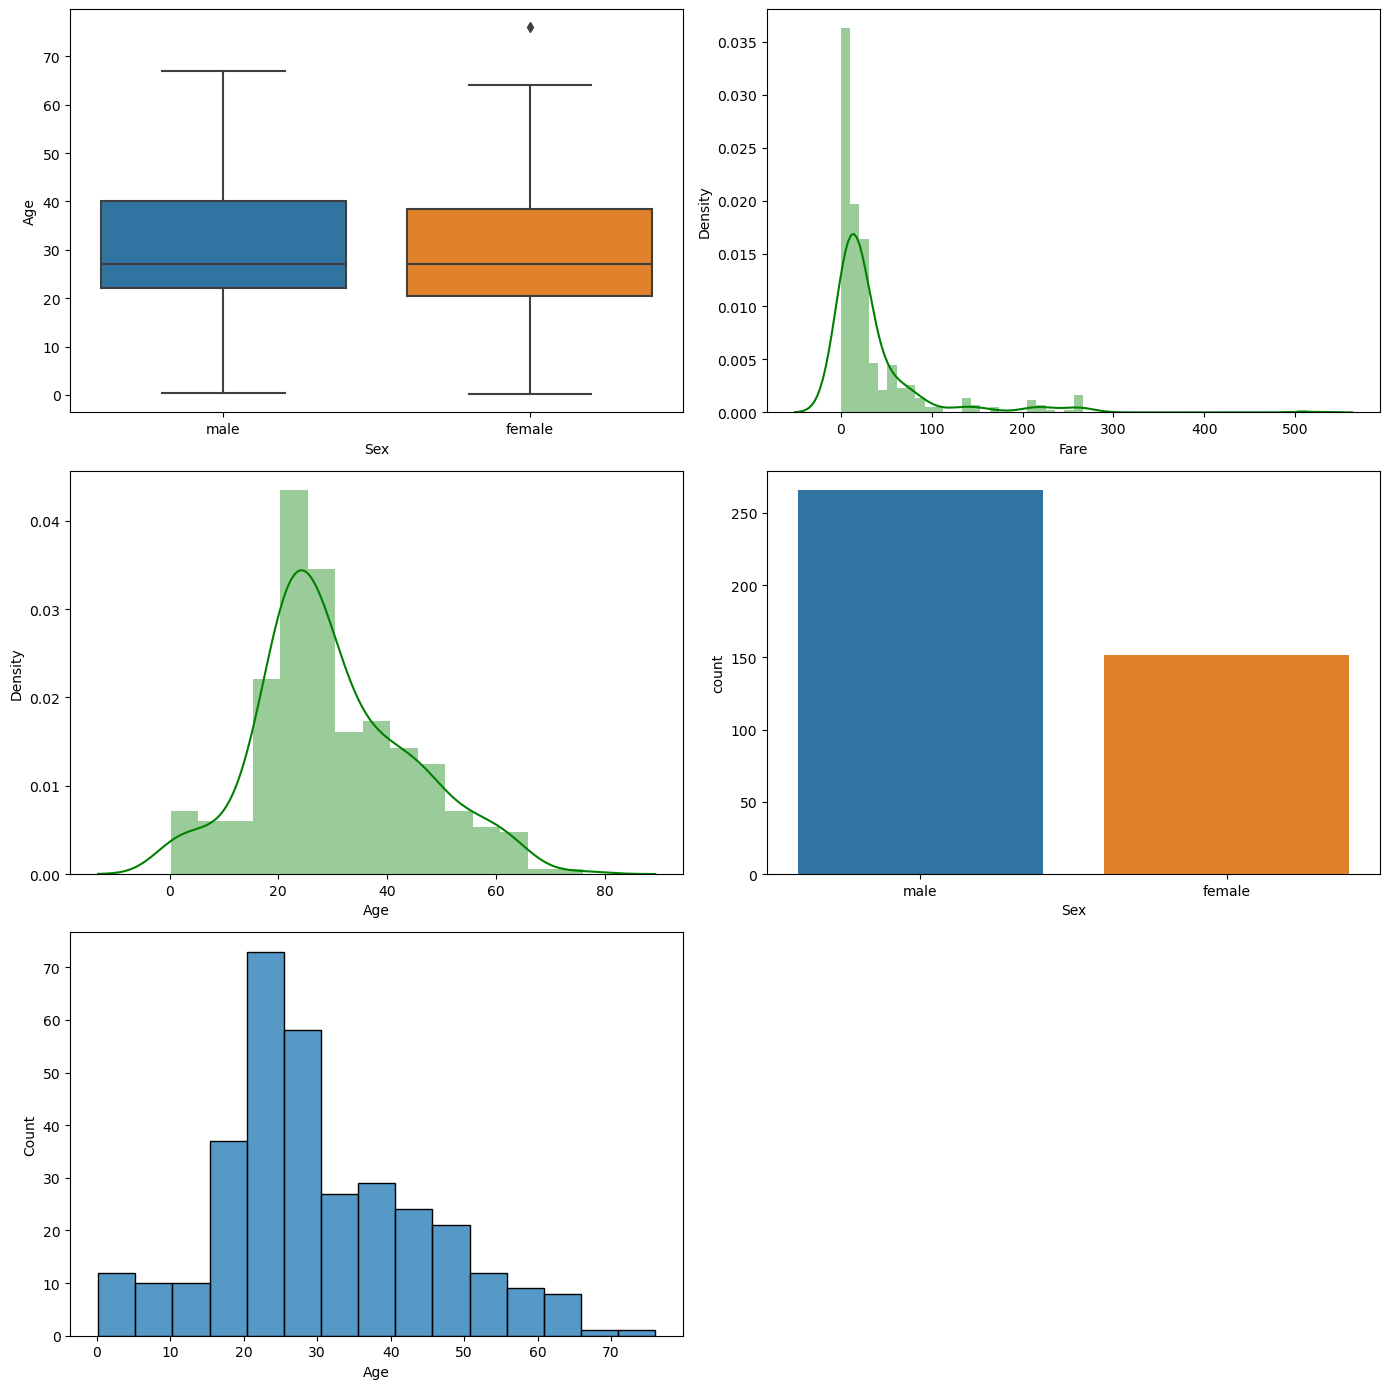

In [4]:
# data visualisation before cleaning data 

plt.figure(figsize=(14,14))
plt.subplot(3,2,1)
sns.boxplot(x='Sex', y = 'Age',data= df)
# "male": 1, "female": 0

plt.subplot(3,2,2)
sns.distplot(df["Fare"],color="g")

plt.subplot(3,2,3)
sns.distplot(df["Age"],color="g")

plt.subplot(3,2,4)
sns.countplot(x="Sex", data=df)

plt.subplot(3,2,5)
sns.histplot(df["Age"])


plt.tight_layout()
plt.show()

In [5]:
try:
    df.drop(columns=["PassengerId", "Name", "Embarked", "Cabin", "Ticket"],inplace=True)
except KeyError:
    pass
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,34.5,0,0,7.8292
1,1,3,female,47.0,1,0,7.0000
2,0,2,male,62.0,0,0,9.6875
3,0,3,male,27.0,0,0,8.6625
4,1,3,female,22.0,1,1,12.2875


In [6]:
df.isna().sum()

Survived     0
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
dtype: int64

In [7]:
df.isna().sum() > 0
# Mozna zrobic to lepiej! Ponizej lepsza metoda
# df['Age'] = df['Age'].fillna(df['Age'].median())
# df['Fare'] = df['Fare'].fillna(df['Fare'].median())

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare         True
dtype: bool

In [8]:
tmp = df.select_dtypes(include=[np.number])
filter = ~tmp.isna()
tmp = tmp.where(filter, tmp.median(), axis=1)
df[tmp.columns] = tmp[tmp.columns]
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,34.5,0,0,7.8292
1,1,3,female,47.0,1,0,7.0000
2,0,2,male,62.0,0,0,9.6875
3,0,3,male,27.0,0,0,8.6625
4,1,3,female,22.0,1,1,12.2875
...,...,...,...,...,...,...,...
413,0,3,male,27.0,0,0,8.0500
414,1,1,female,39.0,0,0,108.9000
415,0,3,male,38.5,0,0,7.2500
416,0,3,male,27.0,0,0,8.0500


In [9]:
df['Sex'] = df['Sex'].map({
                        'male': 1,
                        'female': 0,
                        1: 1,
                        0: 0
                      })

df['Sex'].value_counts()

Sex
1    266
0    152
Name: count, dtype: int64

In [10]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,34.5,0,0,7.8292
1,1,3,0,47.0,1,0,7.0000
2,0,2,1,62.0,0,0,9.6875
3,0,3,1,27.0,0,0,8.6625
4,1,3,0,22.0,1,1,12.2875


In [11]:
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  418 non-null    int64  
 1   Pclass    418 non-null    int64  
 2   Sex       418 non-null    int64  
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Fare      418 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 23.0 KB


In [13]:
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.363636,2.265550,0.636364,29.599282,0.447368,0.392344,35.576535
std,0.481622,0.841838,0.481622,12.703770,0.896760,0.981429,55.850103
min,0.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,1.000000,27.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,1.000000,35.750000,1.000000,0.000000,31.471875
max,1.000000,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200


In [14]:
df.var(axis=0)

Survived       0.231960
Pclass         0.708690
Sex            0.231960
Age          161.385768
SibSp          0.804178
Parch          0.963203
Fare        3119.233971
dtype: float64

/var/folders/ff/xn8h_gc16ll2zb2qh6_dzntm0000gn/T/ipykernel_78008/2424999711.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Fare'],color='g')
/var/folders/ff/xn8h_gc16ll2zb2qh6_dzntm0000gn/T/ipykernel_78008/2424999711.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age'],color='

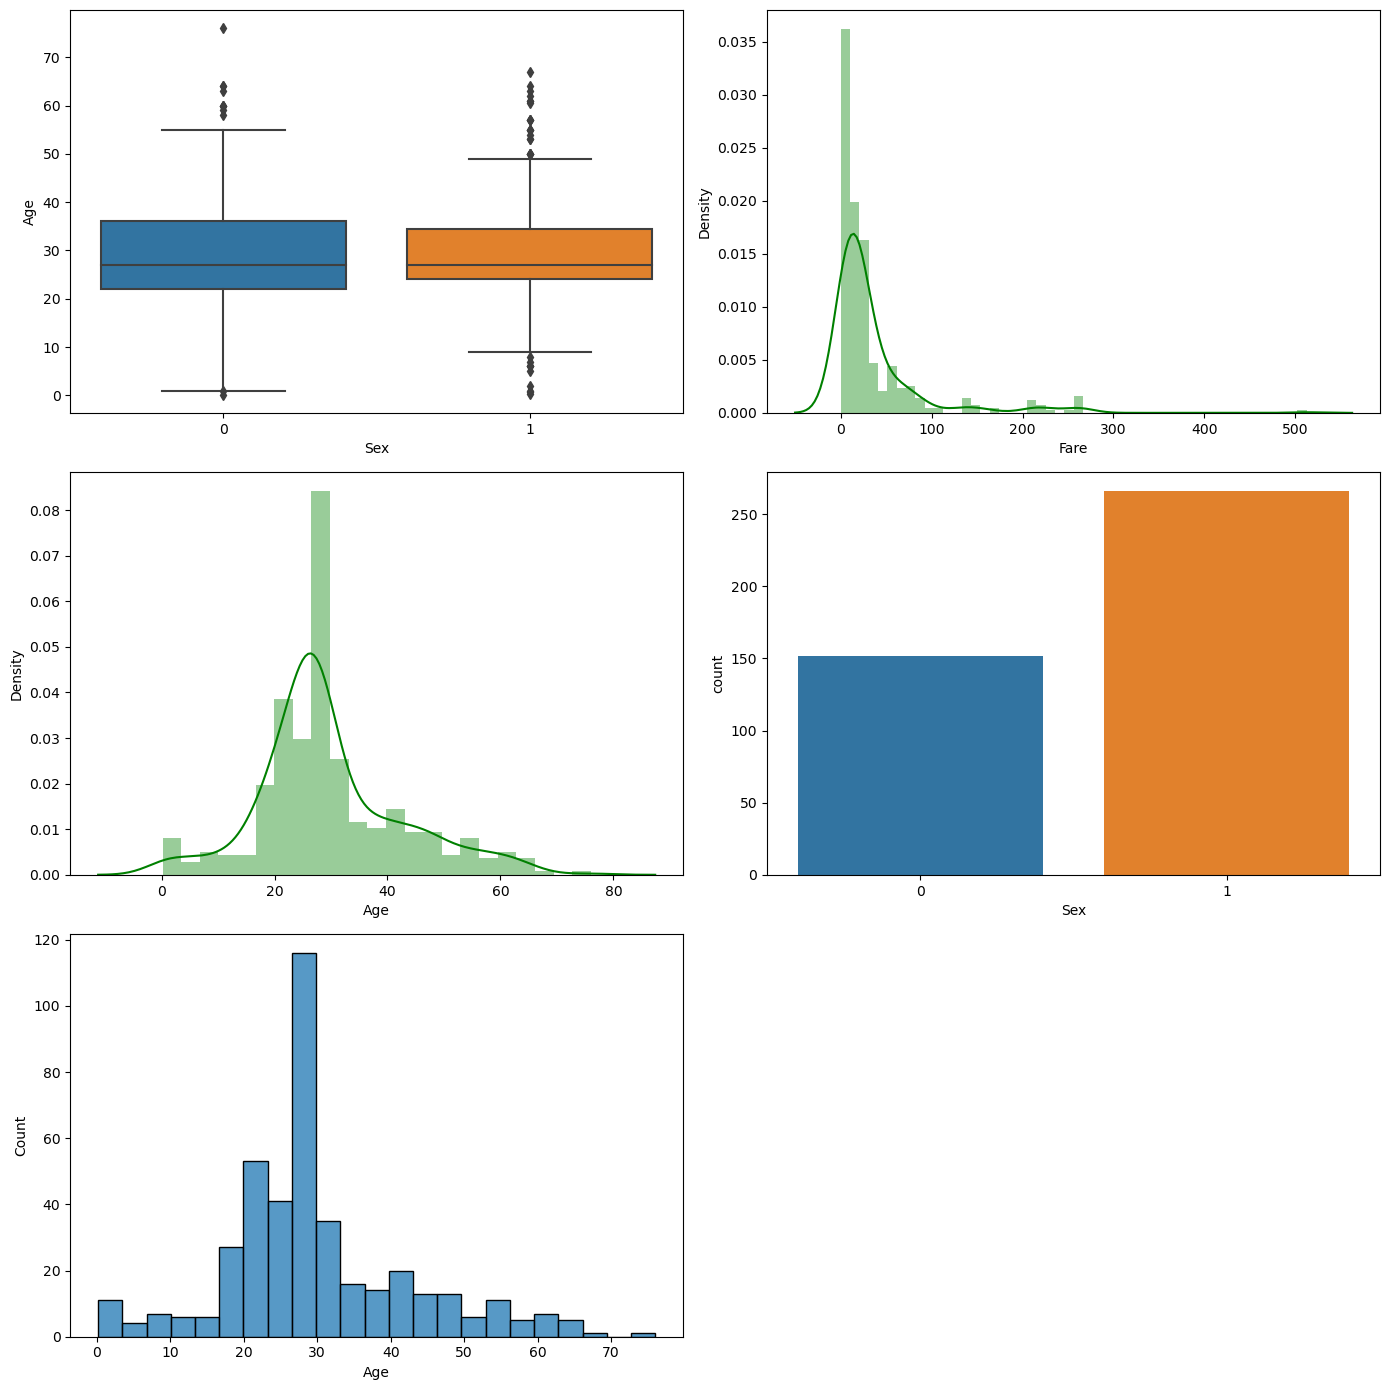

In [15]:
plt.figure(figsize=(14,14))
plt.subplot(3,2,1)
sns.boxplot(x='Sex', y = 'Age',data= df)
# 'male': 1, 'female': 0

plt.subplot(3,2,2)
sns.distplot(df['Fare'],color='g')

plt.subplot(3,2,3)
sns.distplot(df['Age'],color='g')

plt.subplot(3,2,4)
sns.countplot(x='Sex', data=df)

plt.subplot(3,2,5)
sns.histplot(df['Age'])


plt.tight_layout()
plt.show()

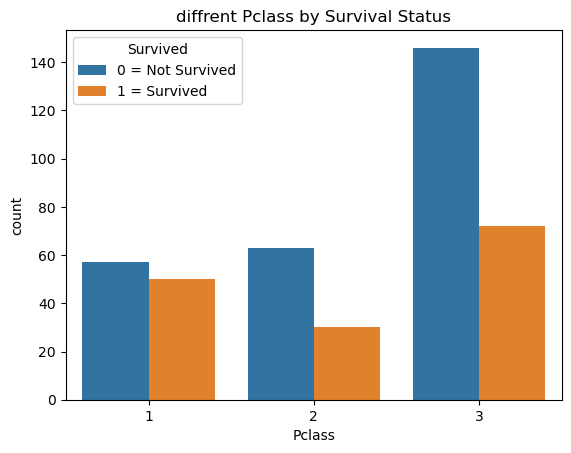

In [16]:
sns.countplot(x='Pclass',data=df,hue='Survived')
legend_labels = {0: 'Not Survived', 1: 'Survived'}
plt.legend(title='Survived', labels=[f"{key} = {value}" for key, value in legend_labels.items()])
plt.title('diffrent Pclass by Survival Status')
plt.show()

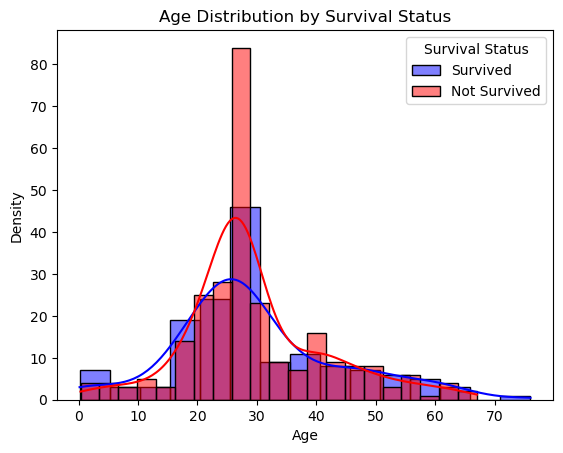

In [17]:
sns.histplot(data=df[df['Survived'] == 1], x='Age', kde=True, color='blue', label='Survived')
sns.histplot(data=df[df['Survived'] == 0], x='Age', kde=True, color='red', label='Not Survived')

plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution by Survival Status')

plt.legend(title='Survival Status')

plt.show()

<Axes: >

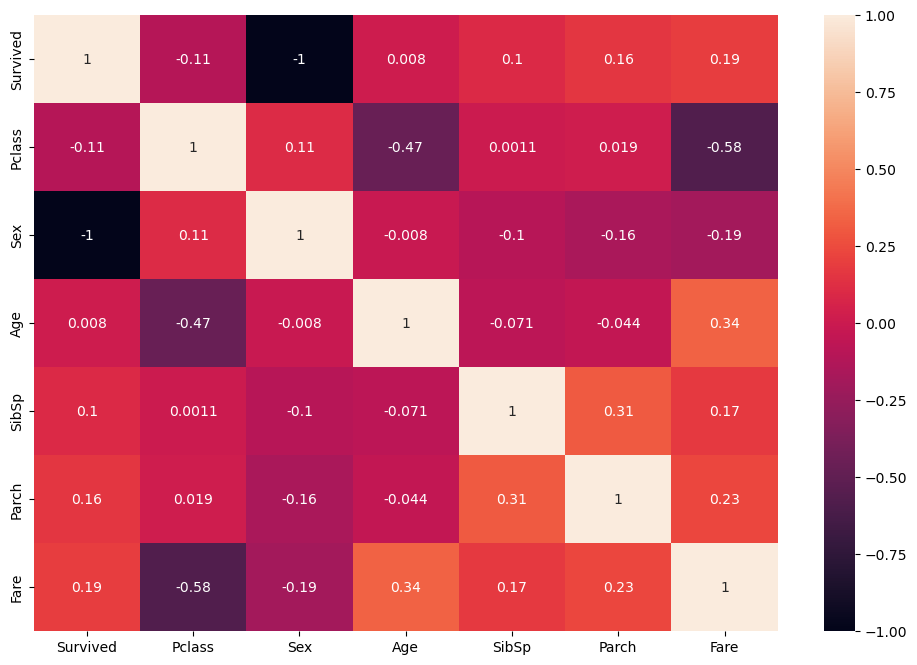

In [18]:
plt.figure(figsize=[12,8])
sns.heatmap(df.corr(),annot=True)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline

In [20]:
x = df.drop(['Survived'],axis=1)
y = df['Survived']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.25, random_state = 45)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
import ydata_profiling
from ydata_profiling import ProfileReport

In [23]:
profile = ProfileReport(df, title="Titanic Dataset", html={'style': {'full_width': True}}, sort=None)

In [24]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
models = {'Logistic Regression': LogisticRegression(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Support Vector Machine': SVC(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'K-Nearest Neighbors': KNeighborsClassifier(),
          'Neural Network': MLPClassifier(max_iter=1000)
          }

In [26]:
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"Logistic Regression - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

Logistic Regression - Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        43

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105




In [27]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"Decision Tree - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

Decision Tree - Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        43

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105




In [28]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"Random Forest - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

Random Forest - Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        43

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105




In [29]:
model = SVC()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"LSupport Vector Machine - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

LSupport Vector Machine - Accuracy: 0.61
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.92      0.74        62
           1       0.58      0.16      0.25        43

    accuracy                           0.61       105
   macro avg       0.60      0.54      0.50       105
weighted avg       0.60      0.61      0.54       105




In [30]:
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"Gradient Boosting - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

Gradient Boosting - Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        43

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105




In [31]:
model = KNeighborsClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"K-Nearest Neighbors - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

K-Nearest Neighbors - Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75        62
           1       0.65      0.56      0.60        43

    accuracy                           0.70       105
   macro avg       0.68      0.67      0.68       105
weighted avg       0.69      0.70      0.69       105




In [32]:
model = MLPClassifier(max_iter=130)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"Neural Network - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

Neural Network - Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        62
           1       0.96      1.00      0.98        43

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105




/Users/katarzynaiwaszkiewicz/anaconda3/envs/MaszLen/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (130) reached and the optimization hasn't converged yet.
  warnings.warn(


In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rand = RandomForestClassifier()
normal = MinMaxScaler()

In [34]:
normal_fit = normal.fit(X_train)
new_xtrain = normal_fit.transform(X_train)
new_xtest = normal_fit.transform(X_test)

In [35]:
fit_rand = rand.fit(new_xtrain, Y_train)
#predicting score
rand_score = rand.score(new_xtest, Y_test)
print('Score of model is : ', rand_score*100,'%')

Score of model is :  100.0 %


In [36]:
X_predict = list(rand.predict(X_test))
predicted_df = {'predicted_values': X_predict,'original_values': Y_test}
print(pd.DataFrame(predicted_df).head(10))
if np.all(predicted_df["predicted_values"] == predicted_df["original_values"]):
    print("All correct!")
else:
    print("Values are mismatched!")
print('Here O = not survived and 1 = survived')

     predicted_values  original_values
376                 1                1
217                 0                0
277                 0                0
335                 0                0
317                 0                0
397                 1                1
282                 1                1
61                  0                0
365                 1                1
333                 1                1
All correct!
Here O = not survived and 1 = survived


/Users/katarzynaiwaszkiewicz/anaconda3/envs/MaszLen/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Here O = not survived and 1 = survived


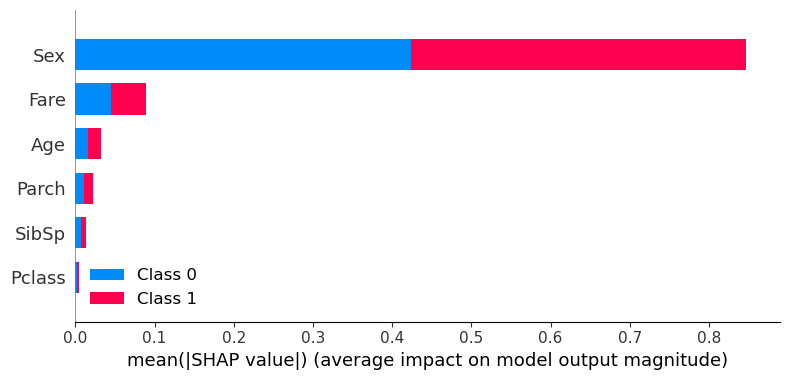

In [43]:
import shap
explainer = shap.TreeExplainer(rand)
shap_values = explainer.shap_values(X_test)
print('Here O = not survived and 1 = survived')
shap.summary_plot(shap_values, X_test)